In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jit_wrap import save_jit_model
from local_mdn import get_argmax_mu

data_train = np.load('data1/noisy_data.npz')

print("Keys in file:", data_train.files)
for key in data_train.files:
    print(f"{key}: shape = {data_train[key].shape}")

Keys in file: ['x', 'y']
x: shape = (800, 1)
y: shape = (800, 1)


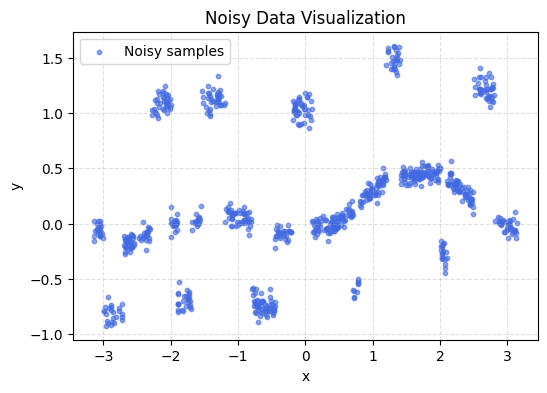

In [2]:
x_train_in = data_train["x"]
y_train_in = data_train["y"]

# Plot
plt.figure(figsize=(6, 4))
plt.scatter(x_train_in, y_train_in, s=10, alpha=0.6, color="royalblue", label="Noisy samples")
plt.title("Noisy Data Visualization")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

Keys in file: ['x', 'y']
x: shape = (800, 1)
y: shape = (800, 1)


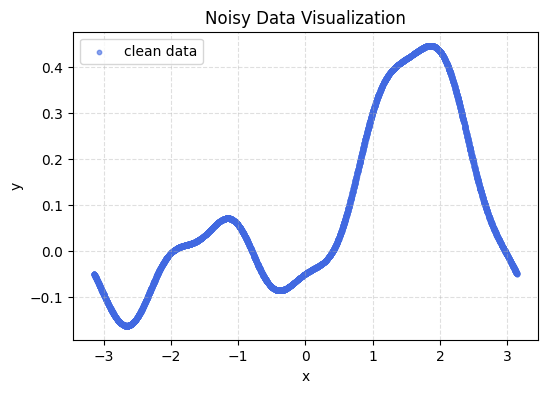

In [3]:
data_test = np.load('data1/clean_data.npz')

print("Keys in file:", data_train.files)
for key in data_train.files:
    print(f"{key}: shape = {data_train[key].shape}")

x_test = data_test["x"]
y_test = data_test["y"]

# Plot
plt.figure(figsize=(6, 4))
plt.scatter(x_test, y_test, s=10, alpha=0.6, color="royalblue", label="clean data")
plt.title("Noisy Data Visualization")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

In [4]:
import sys, torch, os, site
print("Python exe:", sys.executable)
print("torch file:", getattr(torch, "__file__", None))
print("has torch.version? ->", hasattr(torch, "version"))
print("User-site:", site.getusersitepackages())

Python exe: e:\Study_Repos\DL-mid-exam-eval\venv\Scripts\python.exe
torch file: e:\Study_Repos\DL-mid-exam-eval\venv\Lib\site-packages\torch\__init__.py
has torch.version? -> True
User-site: C:\Users\Adit\AppData\Roaming\Python\Python313\site-packages


In [5]:
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
print(torch.__version__)
print("cuda in wheel:", torch.version.cuda)
from util import (
    get_torch_size_string,
    print_model_parameters,
    th2np,
)
from local_mdn import (
    MixtureDensityNetwork,
    gmm_forward,
    eval_mdn_1d,
)

2.9.0+cpu
cuda in wheel: None


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.version.cuda

In [7]:
# when you build the model (keep k=5 if you like)
mdn = MixtureDensityNetwork(
    name='mdn',
    x_dim=1, y_dim=1, k=5,
    h_dim_list=[64,64],
    actv=nn.SiLU(),
    sig_max=15.0,  # <= tighten
    mu_min=-0.01,      # <= widen (in normalized units)
    mu_max=+0.01,
    p_drop=0.0, use_bn=False,
).to(device)
mdn.init_param()
optm = torch.optim.Adam(mdn.parameters(), lr=3e-5, eps=1e-4, weight_decay=1e-4)
schd = torch.optim.lr_scheduler.ExponentialLR(optm, gamma=0.9999)

In [8]:
n_train = 800
x_train = torch.from_numpy(x_train_in).to(device)
y_train = torch.from_numpy(y_train_in).to(device)

In [9]:
max_iter,batch_size,print_every,plot_every = 2e4,128,1000,5000
print ("max_iter:[%d] batch_size:[%d] print_every:[%d] plot_every:[%d]"%
      (max_iter,batch_size,print_every,plot_every))

max_iter:[20000] batch_size:[128] print_every:[1000] plot_every:[5000]


In [10]:
print ("Start training")
np.random.seed(seed=0)
torch.manual_seed(seed=0)
mdn.init_param()
mdn.train()

Start training


MixtureDensityNetwork(
  (actv): SiLU()
  (net): Sequential(
    (linear_00): Linear(in_features=1, out_features=64, bias=True)
    (silu_01): SiLU()
    (dropout1d_02): Dropout1d(p=0.0, inplace=False)
    (linear_03): Linear(in_features=64, out_features=64, bias=True)
    (silu_04): SiLU()
    (dropout1d_05): Dropout1d(p=0.0, inplace=False)
    (mixturesofgaussianlayer_06): MixturesOfGaussianLayer(
      (fc_pi): Linear(in_features=64, out_features=5, bias=True)
      (fc_mu): Linear(in_features=64, out_features=5, bias=True)
      (fc_sigma): Linear(in_features=64, out_features=5, bias=True)
    )
  )
)

Start training
[   0/20000] loss:[6.129]


C:\Users\Adit\AppData\Local\Temp\ipykernel_22728\2026298144.py:23: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  print ("[%4d/%d] loss:[%.3f]"%(it,max_iter,loss))


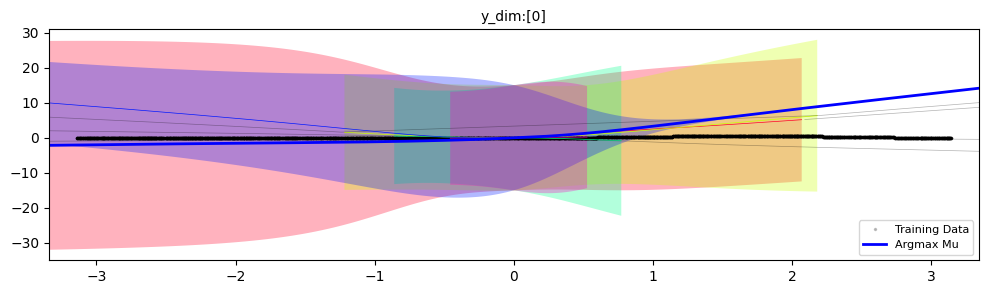

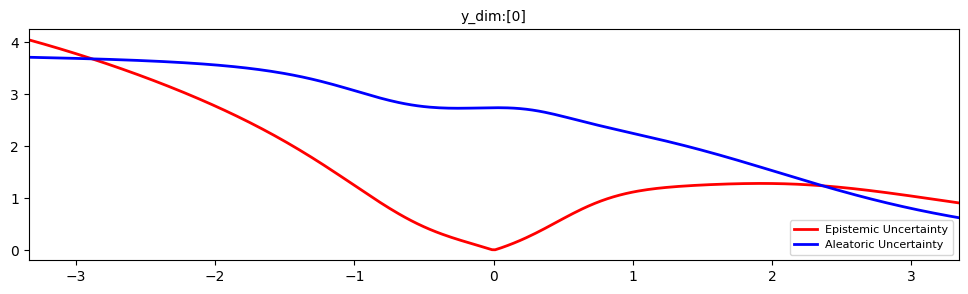

[1000/20000] loss:[1.683]
[2000/20000] loss:[1.488]
[3000/20000] loss:[1.251]
[4000/20000] loss:[1.003]
[5000/20000] loss:[0.910]


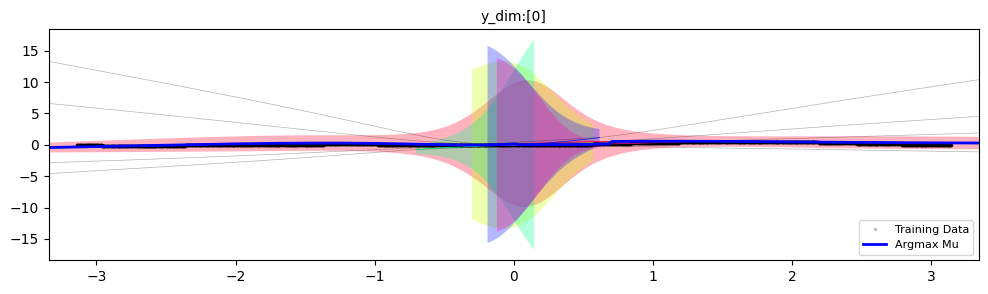

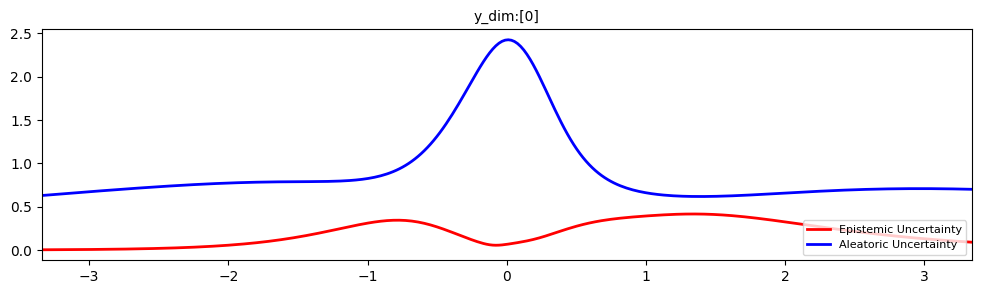

[6000/20000] loss:[0.788]
[7000/20000] loss:[0.898]
[8000/20000] loss:[0.822]
[9000/20000] loss:[0.823]
[10000/20000] loss:[0.684]


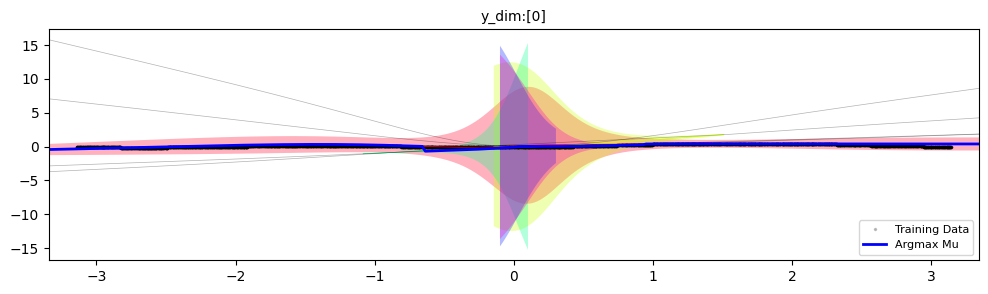

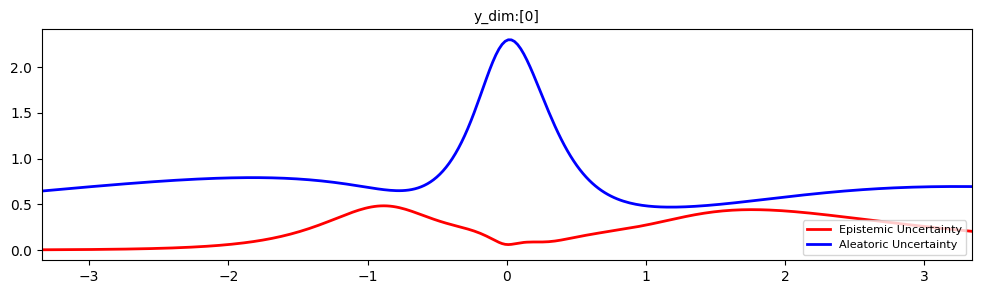

[11000/20000] loss:[0.695]
[12000/20000] loss:[0.727]
[13000/20000] loss:[0.769]
[14000/20000] loss:[0.693]
[15000/20000] loss:[0.521]


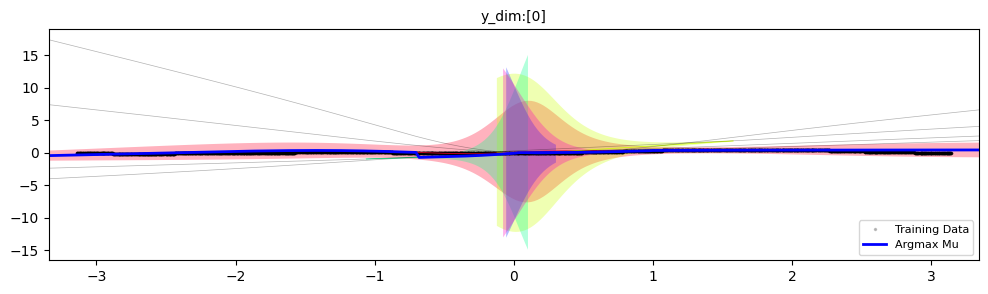

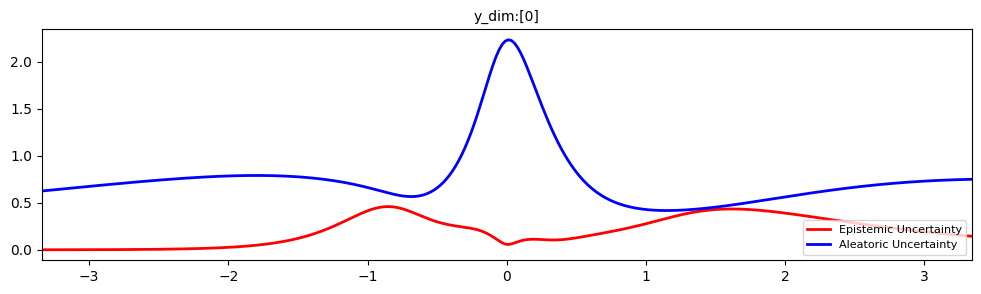

[16000/20000] loss:[0.636]
[17000/20000] loss:[0.705]
[18000/20000] loss:[0.598]
[19000/20000] loss:[0.636]
[19999/20000] loss:[0.630]


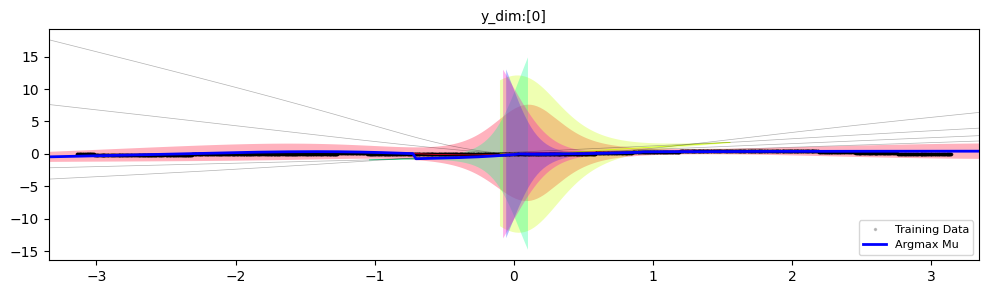

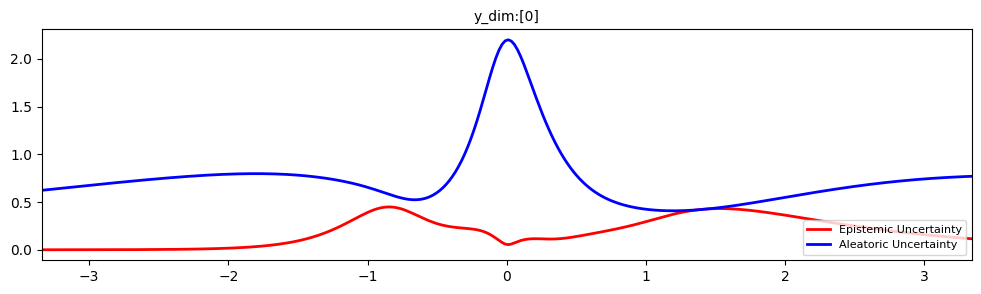

Done.


In [11]:
print ("Start training")
np.random.seed(seed=0)
torch.manual_seed(seed=0)
mdn.init_param()
mdn.train()
x_train = torch.Tensor(x_train_in).to(device)
y_train = torch.Tensor(y_train_in).to(device)

for it in range(int(max_iter)):
    batch_idx = np.random.permutation(n_train)[:batch_size]
    x_batch,y_batch = x_train[batch_idx],y_train[batch_idx]

    # Update
    mdn.zero_grad()
    pi_batch,mu_batch,sigma_batch = mdn.forward(x_batch)
    gmm_out = gmm_forward(pi_batch,mu_batch,sigma_batch,y_batch)
    loss = torch.mean(gmm_out['nlls']) + 0.1*F.mse_loss(y_batch,gmm_out['argmax_mu'])
    loss.backward()
    optm.step()
    schd.step()
    # Print
    if ((it%print_every)==0) or (it==(max_iter-1)):
        print ("[%4d/%d] loss:[%.3f]"%(it,max_iter,loss))

    # Plot
    if ((it%plot_every)==0) or (it==(max_iter-1)):
        eval_mdn_1d(mdn,x_test,y_test,figsize=(12,3),device=device)
print("Done.")
    
    # ... your print/plot stay unchanged ...




Loading validation data 'validation_data.npz'...
Validation data loaded successfully.


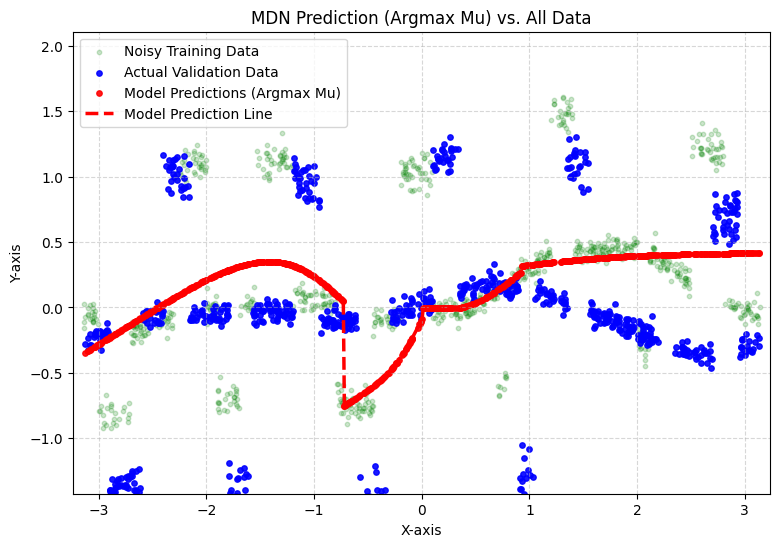

In [12]:
print("Loading validation data 'validation_data.npz'...")
val_data = np.load('./data2/noisy_data.npz')
x_val = val_data['x']
y_val = val_data['y']
print("Validation data loaded successfully.")
    
# Prepare validation data (reshape and convert to tensor)
if x_val.ndim == 1: x_val = x_val.reshape(-1, 1)
if y_val.ndim == 1: y_val = y_val.reshape(-1, 1)

x_val_tensor = torch.tensor(x_val).float()

# Set model to evaluation mode
mdn.eval()

# Get model predictions for the validation set
with torch.no_grad():
    # 1. Get the full GMM parameters
    pi_val, mu_val, sigma_val = mdn(x_val_tensor)
    
    # 2. Get the *most probable* mean (our final prediction)
    #    This is the key! We are no longer using a single, overfitted output.
    y_val_pred_tensor = get_argmax_mu(pi_val, mu_val)

# Convert all data back to NumPy for plotting
y_val_pred_np = th2np(y_val_pred_tensor)
x_val_np = th2np(x_val_tensor)
y_val_np = y_val # Already a numpy array

# Create the scatter plot
plt.figure(figsize=(9, 6))

# Plot the original training data (with noise)
plt.scatter(x_train, y_train, color='green', label='Noisy Training Data', s=10, alpha=0.2)

# Plot the actual validation data (the "ground truth")
plt.scatter(x_val_np, y_val_np, color='blue', label='Actual Validation Data', s=15, alpha=0.9)

# Plot the model's predictions (The most probable mean)
plt.scatter(x_val_np, y_val_pred_np, color='red', label='Model Predictions (Argmax Mu)', s=15, alpha=0.9)

# Plot the prediction line
sort_indices = np.argsort(x_val_np.squeeze())
plt.plot(x_val_np[sort_indices], y_val_pred_np[sort_indices], color='red', linestyle='--', linewidth=2.5, label='Model Prediction Line')

plt.title('MDN Prediction (Argmax Mu) vs. All Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(y_train.min() - 0.5, y_train.max() + 0.5) # Set Y-limits
plt.xlim(x_train.min() - 0.1, x_train.max() + 0.1) # Set X-limits
plt.show()

In [13]:
# exit()
print("\n--- Saving JIT Model ---")
# Ensure the 'model/' directory exists
os.makedirs('../model2', exist_ok=True)

# Set model to evaluation mode (turns off dropout, etc.)
mdn.eval()
JIT_MODEL_PATH = f"../model2/sample.pth"
# Save the JIT-scripted model
save_jit_model(mdn, JIT_MODEL_PATH)


--- Saving JIT Model ---
Wrapping model for JIT tracing...
JIT-traced model saved successfully to ../model2/sample.pth
